Non-Stacked


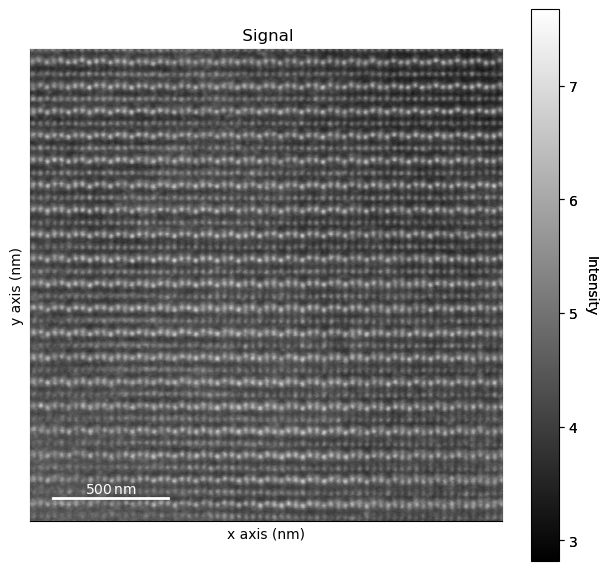

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('../..')
import util.crop

stack_num = 0 # The index of stacked image

s_load = hs.load('../../data/images/Jaume LFO/HAADF_03.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

Too many vertical lines, plotting the first 10 only.


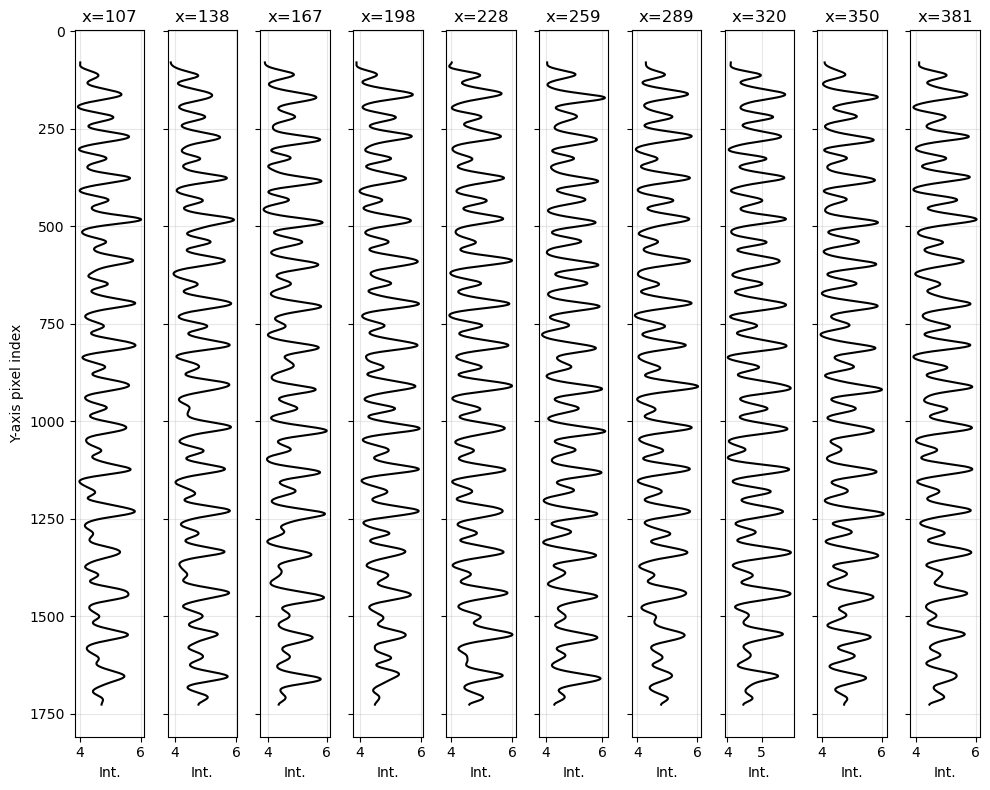

In [2]:
left_bound = 100 # TUNE THIS
right_bound = 2048-100 # TUNE THIS
start_pixel = 80 # TUNE THIS
end_pixel = 2048-320 # TUNE THIS

crop_exp = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)
crop_exp.build_grid_dict()
_ = crop_exp.get_vertical_lines(get_plot=False)
_ = crop_exp.gaussian_filtering(sigma=7, get_plot=True)
peaks_exp = crop_exp.get_vertical_line_peaks()

### Experimental image

In [3]:
def get_segments(crop, Lu_start):
    vlines = crop.vertical_lines
    filtered_vlines = crop.filtered_vertical_lines
    peaks = crop.vertical_line_peaks

    line_units = []
    filtered_line_units = []

    for i in range(len(peaks)):
        Lu_peaks = peaks[i][Lu_start::2]
        Fe_peaks = peaks[i][(Lu_start+1)::2][:len(Lu_peaks)-1]
        for j in range(len(Lu_peaks)-1):
            segment = vlines[i][Lu_peaks[j]:Lu_peaks[j+1]]
            filtered_segment = filtered_vlines[i][Lu_peaks[j]:Lu_peaks[j+1]]

            # Moving them to the same orientation; From DFT results, they are equivalent
            if Lu_peaks[j+1] - Fe_peaks[j] < Fe_peaks[j] - Lu_peaks[j]:
                segment = segment[::-1]
                filtered_segment = filtered_segment[::-1]

            line_units.append(segment)
            filtered_line_units.append(filtered_segment)
    
    return line_units, filtered_line_units

def get_segments_2(crop, Lu_start):
    vlines = crop.vertical_lines
    filtered_vlines = crop.filtered_vertical_lines
    peaks = crop.vertical_line_peaks

    line_units = []
    filtered_line_units = []

    for i in range(len(peaks)):
        Lu_peaks = peaks[i][Lu_start::2]
        Fe_peaks = peaks[i][(Lu_start+1)::2][:len(Lu_peaks)-1]
        for j in range(len(Lu_peaks)-2):
            segment = vlines[i][Lu_peaks[j]:Lu_peaks[j+2]]
            filtered_segment = filtered_vlines[i][Lu_peaks[j]:Lu_peaks[j+1]]

            # Moving them to the same orientation; From DFT results, they are equivalent
            if Lu_peaks[j+1] - Fe_peaks[j] < Fe_peaks[j] - Lu_peaks[j]:
                segment = segment[::-1]
                filtered_segment = filtered_segment[::-1]

            line_units.append(segment)
            filtered_line_units.append(filtered_segment)
    
    return line_units, filtered_line_units


In [4]:
def align_segments_x(segments, target_len=2000):
    """
    Aligns segments of different lengths to exactly the same start and end points.
    target_len should be much larger than the original lengths to preserve noise.
    """
    aligned_data = []
    for seg in segments:
        x_old = np.linspace(0, 1, len(seg))
        x_new = np.linspace(0, 1, target_len)
        
        new_seg = np.interp(x_new, x_old, seg)
        aligned_data.append(new_seg)
        
    return np.array(aligned_data)

def align_segments_y(segments):
    """
    Standardizes each row (segment) to mean 0 and std 1.
    Works on a 2D array where each row is a segment.
    """
    means = np.mean(segments, axis=1, keepdims=True)
    stds = np.std(segments, axis=1, keepdims=True)
    
    aligned = (segments - means) / stds
    return aligned

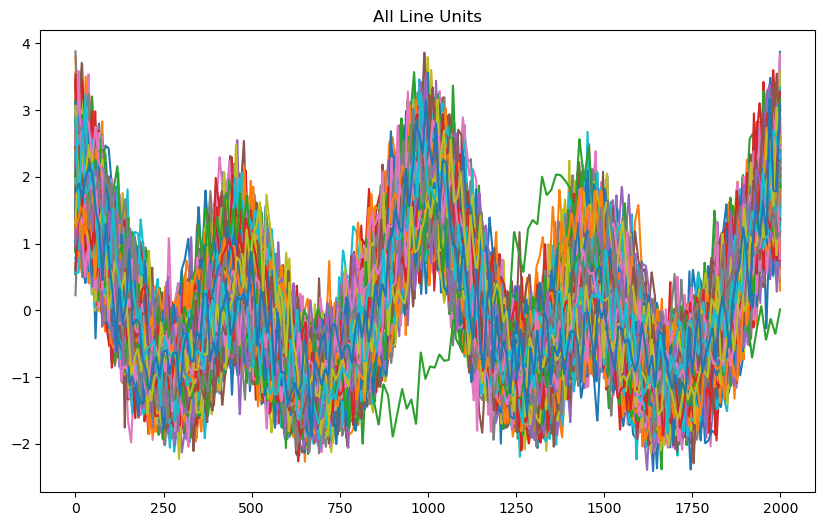

In [5]:
line_units_exp, filtered_line_units_exp = get_segments_2(crop_exp, Lu_start=1)

aligned_vlines_exp = align_segments_y(align_segments_x(line_units_exp))
aligned_filtered_exp = align_segments_y(align_segments_x(filtered_line_units_exp))

plot = True
if plot:
    plt.figure(figsize=(10, 6))
    for i, line_data in enumerate(aligned_vlines_exp):
        plt.plot(line_data, label=f'Unit [{i}]')

    plt.title("All Line Units")
    plt.show()

### Simulations

In [6]:
import itertools

sweep_configs = {
    'energy': [100e3],      # eV
    'Cs': [0],              # in Angstroms
    'layers': [35, 40, 45, 50, 55, 60],     # number of layers along z
    'semiangle_cutoff': [20, 25, 30, 35],      # in milliradians
    'defocus': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],               # in Angstroms
}

batch = 'tests5'
base_path = f"../../data/simulations/{batch}/"
crops = {}
params = {}

keys = sweep_configs.keys()
values = sweep_configs.values()
combinations = list(itertools.product(*values))

for i, combo in enumerate(combinations):
    param = dict(zip(keys, combo))

    e_kev = int(param['energy'] / 1000)
    cs_str = f"{param['Cs']:.1e}"
    cut = param['semiangle_cutoff']
    lay = param['layers']
    defoc = param['defocus']
    
    npy_file = f"noisy_E{e_kev}keV_Cs{cs_str}_Layers{lay}_Cutoff{cut}mrad_Defocus{defoc}.npy"
    full_path = base_path + npy_file
    
    s_sim = hs.load(full_path)
    crop_sim = util.crop.Crop(s_sim)
    crop_sim.build_grid_dict()
    crop_sim.get_vertical_lines()
    _ = crop_sim.gaussian_filtering(get_plot=False)
    peaks_sim = crop_sim.get_vertical_line_peaks()

    crops[i] = crop_sim
    params[i] = param

In [7]:
diffs = {}
for i, crop_sim in crops.items():
    line_units_sim, filtered_line_units_sim = get_segments_2(crop_sim, Lu_start=0)

    aligned_vlines_sim = align_segments_y(align_segments_x(line_units_sim))
    aligned_filtered_sim = align_segments_y(align_segments_x(filtered_line_units_sim))

    mean_sim = np.mean(aligned_vlines_sim, axis=0)
    mean_exp = np.mean(aligned_vlines_exp, axis=0)
    diffs[i] = np.sum(np.abs(mean_sim - mean_exp))

In [8]:
best_index = min(diffs, key=diffs.get)
params[best_index]

{'energy': 100000.0,
 'Cs': 0,
 'layers': 50,
 'semiangle_cutoff': 30,
 'defocus': 40}

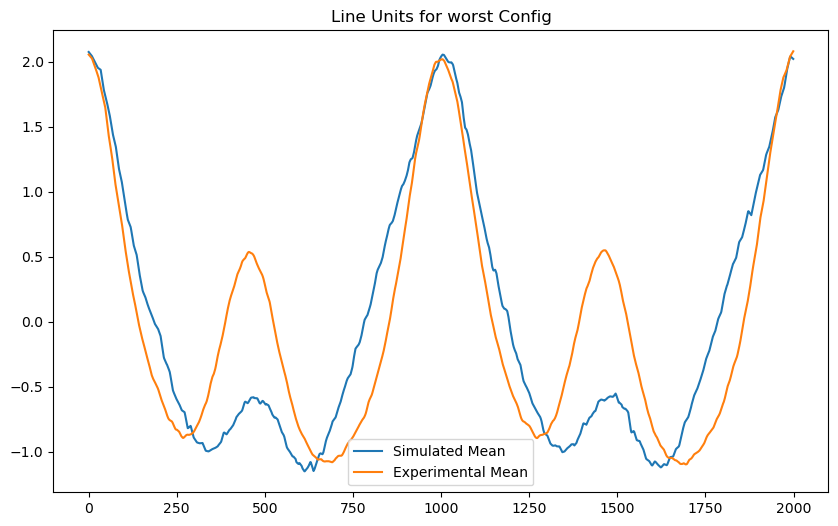

In [9]:
line_units_sim, filtered_line_units_sim = get_segments_2(crops[79], Lu_start=0)

aligned_vlines_sim = align_segments_y(align_segments_x(line_units_sim))
aligned_filtered_sim = align_segments_y(align_segments_x(filtered_line_units_sim))

plt.figure(figsize=(10, 6))
plt.plot(np.mean(aligned_vlines_sim, axis=0), label='Simulated Mean')
plt.plot(np.mean(aligned_vlines_exp, axis=0), label='Experimental Mean')
plt.legend()
plt.title("Line Units for worst Config")
plt.show()

In [10]:
import pandas as pd

# 1. Combine parameters and errors into a single DataFrame
df = pd.DataFrame.from_dict(params, orient='index')
df['mae'] = pd.Series(diffs)

# 2. Calculate the average MAE for every unique value of every parameter
for col in sweep_configs.keys():
    print(f"\n--- Influence of {col} ---")
    analysis = df.groupby(col)['mae'].agg(['mean', 'std', 'min']).sort_values('mean')
    print(analysis)

# 3. Optional: Find the absolute "Best" configuration again to double check
best_row = df.loc[df['mae'].idxmin()]
print(f"\nAbsolute Best Configuration:\n{best_row}")


--- Influence of energy ---
                mean         std         min
energy                                      
100000.0  390.498744  188.465815  168.428209

--- Influence of Cs ---
          mean         std         min
Cs                                    
0   390.498744  188.465815  168.428209

--- Influence of layers ---
              mean         std         min
layers                                    
60      374.178955  157.148002  172.161726
55      376.934033  170.398985  172.367203
50      379.531813  184.255924  168.428209
45      385.396659  199.307419  170.860367
40      401.623459  210.574181  194.228046
35      425.327546  209.619743  204.204374

--- Influence of semiangle_cutoff ---
                        mean         std         min
semiangle_cutoff                                    
20                309.147019   97.079348  194.228046
25                374.449035  178.155405  170.860367
30                422.156789  204.015542  168.428209
35               

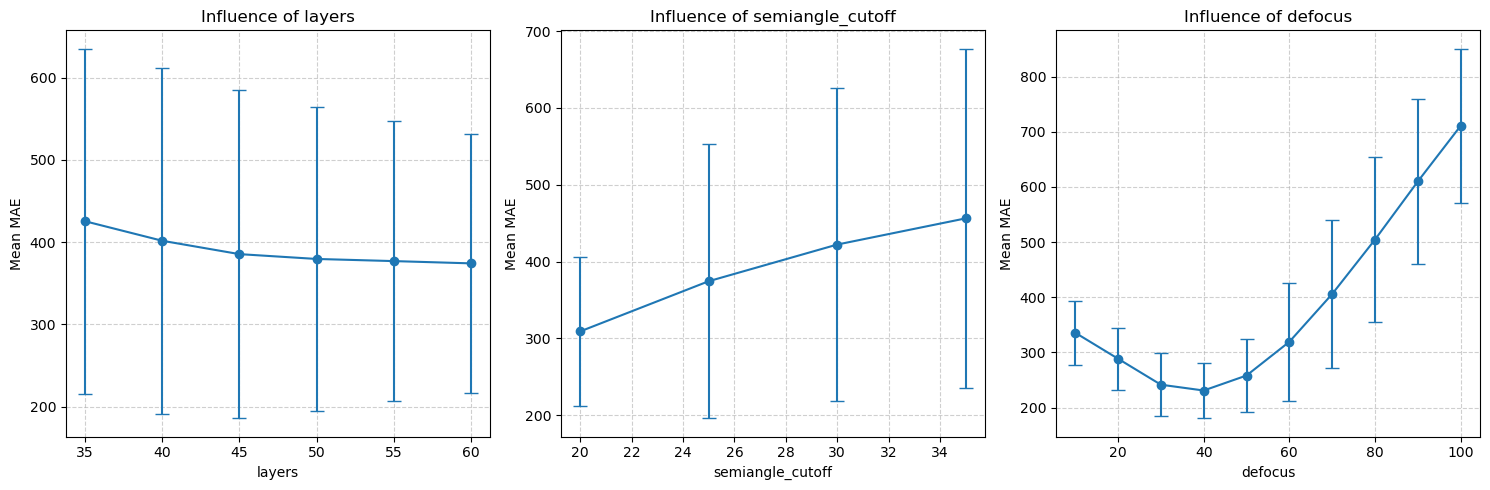

In [11]:
import matplotlib.pyplot as plt

# 1. Identify parameters that vary (don't plot constants like energy/Cs if they didn't change)
cols_to_plot = [col for col in sweep_configs.keys() if df[col].nunique() > 1]

# 2. Create a grid of subplots
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(5 * len(cols_to_plot), 5), squeeze=False)

for i, col in enumerate(cols_to_plot):
    # Calculate mean and std for error bars
    stats = df.groupby(col)['mae'].agg(['mean', 'std']).sort_index()
    
    # Plotting mean with error bars (capsize=5 adds the horizontal lines to error bars)
    stats['mean'].plot(kind='line', marker='o', ax=axes[0, i], yerr=stats['std'], capsize=5)
    
    axes[0, i].set_title(f'Influence of {col}')
    axes[0, i].set_ylabel('Mean MAE')
    axes[0, i].set_xlabel(col)
    axes[0, i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

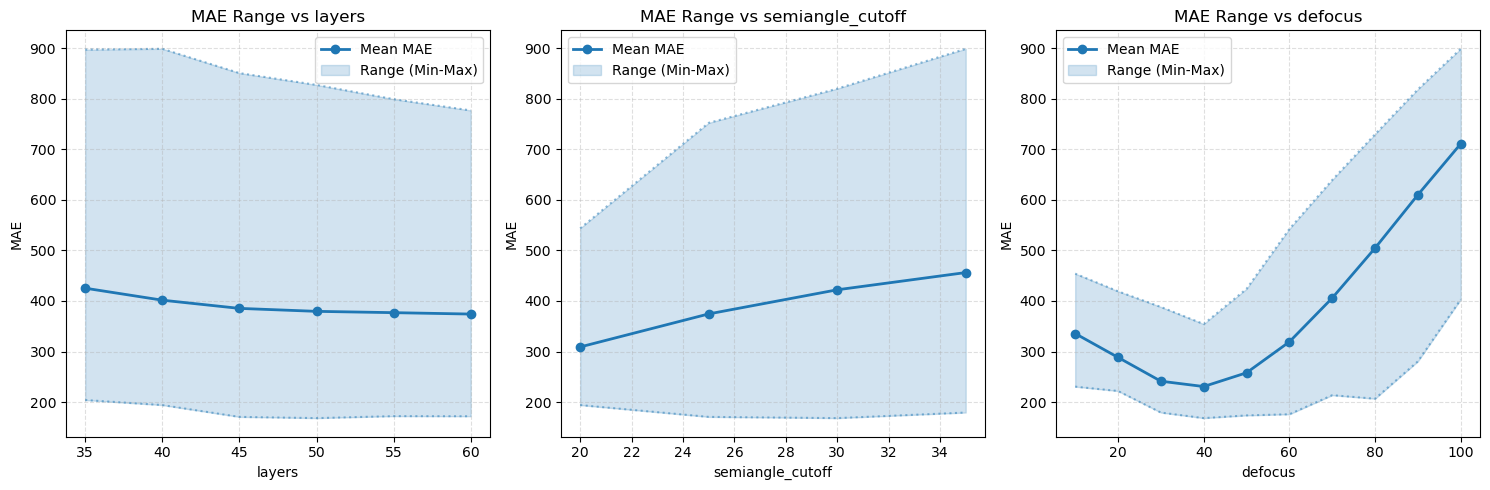

In [14]:
import matplotlib.pyplot as plt

# 1. Identify parameters that vary
cols_to_plot = [col for col in sweep_configs.keys() if df[col].nunique() > 1]

# 2. Create the grid
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(5 * len(cols_to_plot), 5), squeeze=False)

for i, col in enumerate(cols_to_plot):
    # Calculate stats including min and max for the range
    stats = df.groupby(col)['mae'].agg(['mean', 'min', 'max']).sort_index()
    
    # Plot the Mean line
    axes[0, i].plot(stats.index, stats['mean'], marker='o', label='Mean MAE', color='tab:blue', linewidth=2)
    
    # Fill the range (Area between Min and Max)
    axes[0, i].fill_between(stats.index, stats['min'], stats['max'], 
                            color='tab:blue', alpha=0.2, label='Range (Min-Max)')
    
    # Optional: Plot min/max as thin lines to make the boundary sharper
    axes[0, i].plot(stats.index, stats['min'], color='tab:blue', linestyle=':', alpha=0.5)
    axes[0, i].plot(stats.index, stats['max'], color='tab:blue', linestyle=':', alpha=0.5)
    
    axes[0, i].set_title(f'MAE Range vs {col}')
    axes[0, i].set_ylabel('MAE')
    axes[0, i].set_xlabel(col)
    axes[0, i].legend()
    axes[0, i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

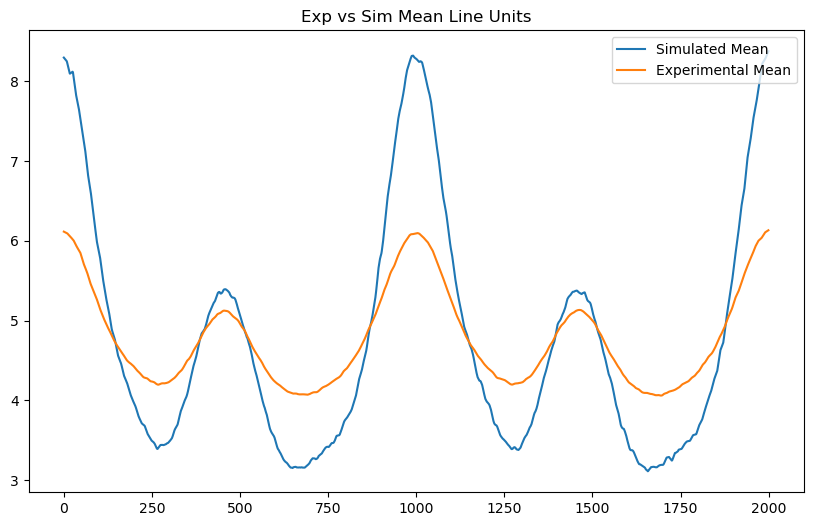

In [12]:
line_units_sim, filtered_line_units_sim = get_segments_2(crops[143], Lu_start=0)

mean_aligned_vlines_sim = np.mean(align_segments_x(line_units_sim), axis=0)
mean_aligned_filtered_sim = np.mean(align_segments_x(filtered_line_units_sim), axis=0)

mean_aligned_vlines_exp = np.mean(align_segments_x(line_units_exp), axis=0)
mean_aligned_vlines_sim = mean_aligned_vlines_sim * (np.mean(mean_aligned_vlines_exp) / np.mean(mean_aligned_vlines_sim))

plt.figure(figsize=(10, 6))
plt.plot(mean_aligned_vlines_sim, label='Simulated Mean')
plt.plot(mean_aligned_vlines_exp, label='Experimental Mean')
plt.legend()
plt.title("Exp vs Sim Mean Line Units")
plt.show()

In [13]:
params[134]

{'energy': 100000.0,
 'Cs': 0,
 'layers': 50,
 'semiangle_cutoff': 25,
 'defocus': 50}